### Internal Tracer Content budget
Calculate the terms in the internal tracer budget (a generalization of the internal heat content budget of Holmes et al., 2018):  
$$ \frac{\partial \Phi_I}{\partial t}(\phi,t) = \mathcal{F}(\phi,t) + \mathcal{P}_I(\phi,t) + \mathcal{K}(\phi,t) + \mathcal{I}(\phi,t) + \mathcal{B}(\phi,t)\, ,$$
where  
$$\Phi_I(\phi,t) = \mathcal{M}(\phi,t)[\overline{\phi} - \phi]$$  
is the "internal tracer content". Here $\mathcal{M}(\phi,t)$ is the mass of water with tracer concentration less than $\phi$ and $\overline{\phi}$ is the mass-weighted average tracer contration in that mass.  
$\mathcal{F}$ is the diffusive surface tracer flux, $\mathcal{K}$ and $\mathcal{I}$ are parameterized and numerical mixing respectively, $\mathcal{P}_I(\phi,t)$ is the internal component of the surface tracer flux due to surface mass fluxes (i.e. $P-E+R$), and $\mathcal{B}$ is a source/sink term for reactive tracers.

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import budgetcalcs as bc
import calc_wmt as wmt

In [2]:
from distributed import Client, LocalCluster, progress
from dask_jobqueue import SLURMCluster

cluster = LocalCluster(
    threads_per_worker=16,
    n_workers=2,
    dashboard_address=8726,
    processes=False)

client = Client(cluster)
client

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8726 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: inproc://140.208.147.171/12453/1 Dashboard: http://140.208.147.171:38793/status,Cluster Workers: 2 Cores: 32 Memory: 541.57 GB


In [3]:
# rootdir = '/archive/gam/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/1yr/'
rootdir = '/archive/gam/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/7/history/'
averaging = '5daily'
vgrid = 'native'
dtst = '08990101'
ds = {}
files = ['common','heat','salt','thk','o2','no3']
for f in files:
    print('Loading '+f+'.')
    if f=='common':
        filename = dtst+'.ocean_'+averaging+'_'+vgrid+'_'+dtst[0:2]+'*.nc'
    else:
        filename = dtst+'.ocean_'+f+'_'+averaging+'_'+vgrid+'_'+dtst[0:2]+'*.nc'
    ds[f] = xr.open_mfdataset(rootdir+filename, chunks={'time': 1}, combine='by_coords')
    
filename_grid = dtst+'.ocean_static.nc'
delta_t = ds['heat']['average_DT'].astype('timedelta64[s]')
grid = xr.open_dataset(rootdir+filename_grid)
area = grid['areacello']

rho0 = 1035.0
cp = 3992.0

if vgrid == 'z':
    ds = ds.rename({'z_l':'zl'})

filename_snap = dtst+'.ocean_'+averaging+'_'+vgrid+'_snap*.nc'
ds_snap = xr.open_mfdataset(rootdir+filename_snap, chunks={'time': 1}, combine='by_coords')

Loading common.


/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


Loading heat.


/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


Loading salt.


/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


Loading thk.


/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


Loading o2.


/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


Loading no3.


/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [4]:
# Budget terms
terms = {}
terms['heat'] = ['opottemptend','T_advection_xy','Th_tendency_vert_remap',
              'boundary_forcing_heat_tendency','internal_heat_heat_tendency',
              'opottempdiff','opottemppmdiff','frazil_heat_tendency']
terms['salt'] = ['osalttend','S_advection_xy','Sh_tendency_vert_remap',
              'boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']
terms['h'] = ['dhdt','dynamics_h_tendency','vert_remap_h_tendency',
           'boundary_forcing_h_tendency']
terms['o2'] = ['o2h_tendency','o2_advection_xy','o2h_tendency_vert_remap',
            'o2_dfxy_cont_tendency','o2_vdiffuse_impl','jo2']
terms['no3'] = ['no3h_tendency','no3_advection_xy','no3h_tendency_vert_remap',
              'no3_dfxy_cont_tendency','no3_vdiffuse_impl','jno3']

l_is = {}
l_is['heat'] = np.arange(-4,34,0.5)
l_is['o2'] = np.arange(-5E-4,5.5E-4,0.5E-6)
l_is['no3'] = np.arange(-5E-5,3E-4,0.5E-5)

In [5]:
# Corrections for o2 budget
# Correct MOM6 tendencies to account for mass in cell
# i.e. convert from [mol kg^-1 m s^-1] to [mol m^-2 s^-1]
for term in terms['o2'][:-1]:
    ds['o2'][term] *= rho0
    
### THIS A HACK WHILE I WORK OUT THE VDIFFUSE_IMPL TERMS ###
# Calculate residual error
# OXYGEN
tendsum,error = bc.calc_budget(ds['o2'],terms['o2'][1:],terms['o2'][0],plot=False)
ds['o2']['o2_vdiffuse_impl']=error

# Corrections for no3 budget
# Correct MOM6 tendencies to account for mass in cell
# i.e. convert from [mol kg^-1 m s^-1] to [mol m^-2 s^-1]
for term in terms['no3'][:-1]:
    ds['no3'][term] *= rho0
    
### THIS A HACK WHILE I WORK OUT THE VDIFFUSE_IMPL TERMS ###
# Calculate residual error
# OXYGEN
tendsum,error = bc.calc_budget(ds['no3'],terms['no3'][1:],terms['no3'][0],plot=False)
ds['no3']['no3_vdiffuse_impl']=error

In [6]:
l_name = 'o2'
if l_name == 'temp':
    ds_name = 'heat'
else:
    ds_name = l_name
    
greaterthan = False
    
# Time-mean fields
l = ds[ds_name][l_name] # tracer

# Snapshots: for evaluating budget tracer content tendency
# NOTE: time-mean i corresponds to the snapshots at i and i-1
# so, for example, diff(snap[1]-snap[0])/dt = mean[1]
l_snap = ds_snap[l_name] # Snapshots of volume-defining tracer
h_snap = ds_snap['thkcello'] # Snapshots of layer thickness (for tracer content calculation)

In [7]:
# Tricky case: all contours
l_i_vals = l_is[l_name]

In [8]:
# Tracer content tendency
L = wmt.calc_P(rho0*l_snap*h_snap,l_snap,l_i_vals,area,greaterthan=greaterthan)
V = wmt.calc_P(h_snap,l_snap,l_i_vals,area,greaterthan=greaterthan)
dL = L.diff('time').assign_coords({'time':l['time'][1:]})
dV = V.diff('time').assign_coords({'time':l['time'][1:]})
dLdt = dL/delta_t[1:].astype('float')
dVdt = dV/delta_t[1:].astype('float')
dLidt = (dLdt-rho0*dVdt*dVdt[l_name+'_bin'])

In [9]:
# Forcing tendencies
forcing = {}
for term in terms[l_name][3:]:
    forcing[term] = wmt.calc_P(ds[ds_name][term],l,l_i_vals,area,greaterthan=greaterthan)[1:,:]

In [11]:
# External surface forcing
p_e = ds['thk']['boundary_forcing_h_tendency']
P_e = wmt.calc_P(p_e,l,l_i_vals,area,greaterthan=greaterthan)[1:,:]
P_e = rho0*P_e*P_e[l_name+'_bin']

In [12]:
%%time
# Load the bits that are needed
print('Loading dLidt.')
dLidt.load()
for term in terms[l_name][3:]:
    print('Loading '+term+'.')
    forcing[term].load()
P_e.load()

Loading dLidt.
Loading o2_dfxy_cont_tendency.
Loading o2_vdiffuse_impl.
Loading jo2.
CPU times: user 20min 35s, sys: 24min 7s, total: 44min 42s
Wall time: 14min 26s


<xarray.DataArray (time: 72, o2_bin: 2100)>
array([[      -0.        ,       -0.        ,       -0.        , ...,
         -679660.41444881,  -680279.69500867,  -680898.97556853],
       [      -0.        ,       -0.        ,       -0.        , ...,
         -827335.15603349,  -828088.99216655,  -828842.82829961],
       [      -0.        ,       -0.        ,       -0.        , ...,
        -1086916.59431332, -1087906.95111907, -1088897.30792482],
       ...,
       [      -0.        ,       -0.        ,       -0.        , ...,
          -11959.57612628,   -11970.47323437,   -11981.37034245],
       [      -0.        ,       -0.        ,       -0.        , ...,
         -396614.09881301,  -396975.47840191,  -397336.8579908 ],
       [      -0.        ,       -0.        ,       -0.        , ...,
         -397232.87732245,  -397594.82071865,  -397956.76411484]])
Coordinates:
  * time     (time) object 0899-01-08 12:00:00 ... 0899-12-29 12:00:00
  * o2_bin   (o2_bin) float64 -0.0004997 -0.0004993 ... 0.0005492 0.0005497

In [15]:
residual = dLidt.copy()
for term in terms[l_name][3:]:
    residual -= forcing[term]
residual += P_e

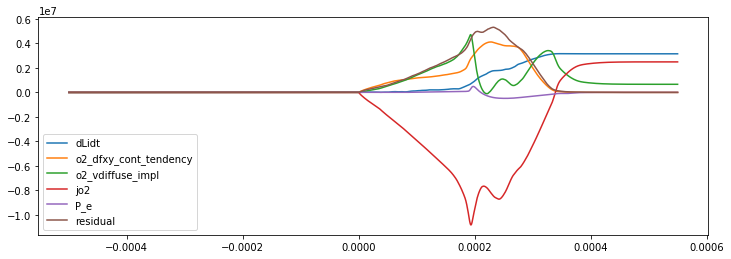

In [16]:
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(dLidt[l_name+'_bin'],dLidt.mean('time'),label='dLidt')
for term in terms[l_name][3:]:
    ax.plot(forcing[term][l_name+'_bin'],forcing[term].mean('time'),label=term)
ax.plot(P_e[l_name+'_bin'],P_e.mean('time'),label='P_e')
ax.plot(residual[l_name+'_bin'],residual.mean('time'),label='residual')

ax.legend()

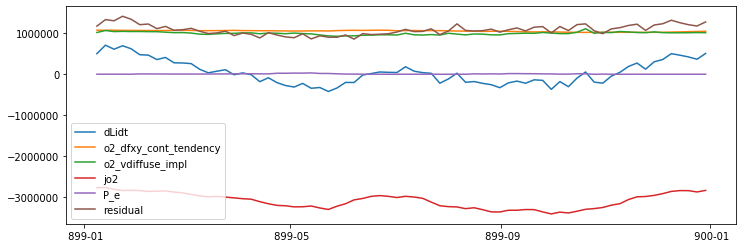

In [18]:
l_c = 80E-6
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(dLidt['time'],dLidt.sel({l_name+'_bin':l_c},method='nearest'),label='dLidt')
for term in terms[l_name][3:]:
    ax.plot(forcing[term]['time'],forcing[term].sel({l_name+'_bin':l_c},method='nearest'),label=term)
ax.plot(P_e['time'],P_e.sel({l_name+'_bin':l_c},method='nearest'),label='P_e')
ax.plot(residual['time'],residual.sel({l_name+'_bin':l_c},method='nearest'),label='residual')
ax.legend()

***
### SINGLE CONTOUR

In [16]:
# Simple case: single contour
l_c = 0        # tracer contour value
volume = l > l_c # condition for volume defined by contour
volume_snap = l_snap > l_c

In [17]:
# Tracer content tendency
L = (rho0*cp*l_snap*h_snap*area).where(volume_snap,0).sum(['xh','yh','zl'])
V = (h_snap*area).where(volume_snap,0).sum(['xh','yh','zl'])
dL = L.diff('time').assign_coords({'time':ds['time'][1:]})
dV = V.diff('time').assign_coords({'time':ds['time'][1:]})
dLdt = dL/delta_t[1:].astype('float')
dVdt = dV/delta_t[1:].astype('float')
dLidt = dLdt-rho0*cp*l_c*dVdt

In [18]:
# Forcing tendencies
F = (f*area).where(volume,0).sum(['xh','yh','zl'])[1:].load()
G = (g*area).where(volume,0).sum(['xh','yh','zl'])[1:].load()
M = (m*area).where(volume,0).sum(['xh','yh','zl'])[1:].load()
K = (k*area).where(volume,0).sum(['xh','yh','zl'])[1:].load()
Z = (z*area).where(volume,0).sum(['xh','yh','zl'])[1:].load()

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


In [20]:
# Internal surface forcing
p_e = ds['boundary_forcing_h_tendency']*rho0*cp*l_c
P_e = (p_e*area).where(volume,0).sum(['xh','yh','zl'])[1:].load()
F_i = F - P_e

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


In [21]:
# Residual
residual = dLidt-F_i-G-M-K-Z

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


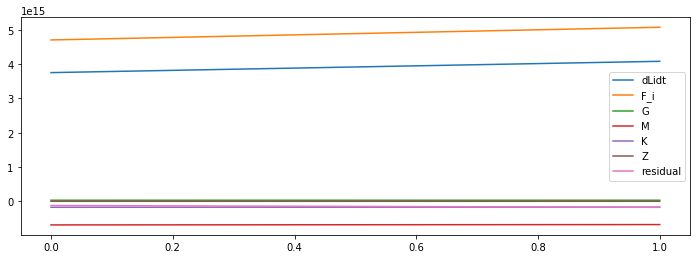

In [22]:
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(dLidt,label='dLidt')
ax.plot(F_i,label='F_i')
ax.plot(G,label='G')
ax.plot(M,label='M')
ax.plot(K,label='K')
ax.plot(Z,label='Z')
ax.plot(residual,label='residual')

ax.legend()

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


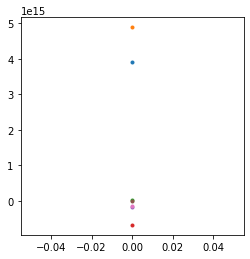

In [23]:
fig,ax = plt.subplots(figsize=(4,4))
ax.plot(0,dLidt.mean('time').values,'.')
ax.plot(0,F_i.mean('time').values,'.')
ax.plot(0,G.mean('time').values,'.')
ax.plot(0,M.mean('time').values,'.')
ax.plot(0,K.mean('time').values,'.')
ax.plot(0,Z.mean('time').values,'.')
ax.plot(0,residual.mean('time').values,'.')